# Interpolating unevenly spaced XYZ dish surface

Part of our LASSI data analysis pipeline involves:
   * taking in the xyz leica scanner data
   * converting it to spherical coordinates
   * smoothing in this coordinate system
   * converting back to cartesian (XYZ) coordinates
   
This results in an unevenly spaced XYZ dish surface.  We need to interpolate it again so that it is evenly spaced, such that we can then fit it for zernike coefficients.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

### Load the unevenly spaced XYZ dish surface

In [2]:
import numpy as np
from copy import copy
fn = "smoothXYZ50.npz"
r = np.load(fn)
x = r['x']
y = r['y']
z = r['z']
orgX = copy(x)
orgY = copy(y)
orgZ = copy(z)

<IPython.core.display.Javascript object>


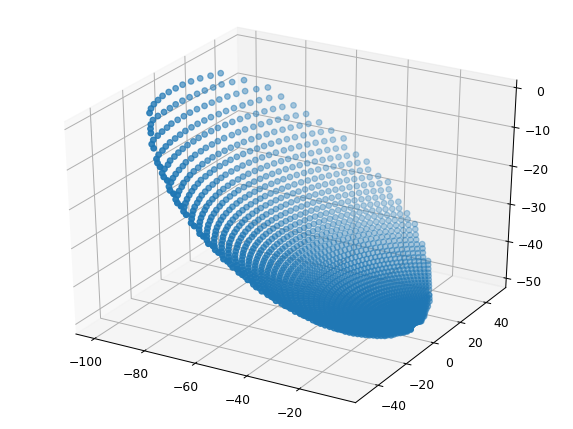

In [3]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(x, y, z)

Careful, there are NaNs in this dataset.

In [4]:
xMax = np.nanmax(x)
xMin = np.nanmin(x)
yMax = np.nanmax(y)
yMin = np.nanmin(y)

print np.isnan(x).any()
print np.isnan(y).any()
print np.isnan(z).any()


True
True
True


 ### Use scipy to interpolate this 2D surface
    We'll replace the NaN's with zero's and flatten our coordinate matrices to fit an interpolation function to all our data

In [5]:
    from scipy import interpolate

    x[np.isnan(x)] = 0.
    y[np.isnan(y)] = 0.
    z[np.isnan(z)] = 0.
    
    f = interpolate.interp2d(x.flatten(),
                             y.flatten(),
                             z.flatten(),
                             kind='cubic')    

/home/sandboxes/pmargani/lassi-analysis/pmargani_lassi_env/lib/python2.7/site-packages/scipy/interpolate/_fitpack_impl.py:976: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=28,26 m=2500 fp=169.935411 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


### Avoid the edges when using this interpolation function

We have not yet figured out how to deal with the edges and beyond of the surface,
so we will use our interpolation function to make an evenly spaced XYZ surface only
in the center region of our surface.

In [6]:
n = 50

d = 3.

xD = xMax - xMin
xStart = xMin + ((1/d)*xD)
xEnd = xMin + (((d-1)/d)*xD)
    
yD = yMax - yMin
yStart = yMin + ((1/d)*yD)
yEnd = yMin + (((d-1)/d)*yD)

xnew = np.linspace(xStart, xEnd, n)
    
ynew = np.linspace(yStart, yEnd, n)

# our new surface!
znew = f(xnew, ynew)       

# and the evenly spaced meshgrid we need!
mx, my = np.meshgrid(xnew, ynew)

### Visualize result, removing bad points
Here, we simply define bad points as being ones that 
are outside the original range of the original data

In [7]:

lgtMax = znew > np.nanmax(orgZ)
if lgtMax.any():
    print "Replacing values greater then original with NaNs"
    znew[lgtMax] = np.nan
lstMin = znew < np.nanmin(orgZ)
if lstMin.any():
    print "Replacing values less then original with NaNs"
    znew[lstMin] = np.nan

<IPython.core.display.Javascript object>


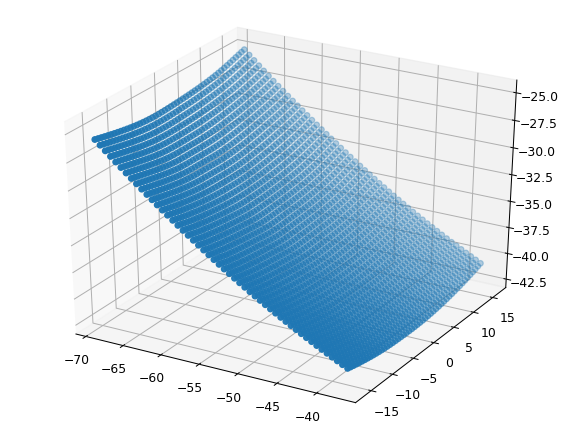

In [8]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(mx, my, znew)

### Now we can fit this using Zernikie Polynomials!
Just for kicks!

<IPython.core.display.Javascript object>


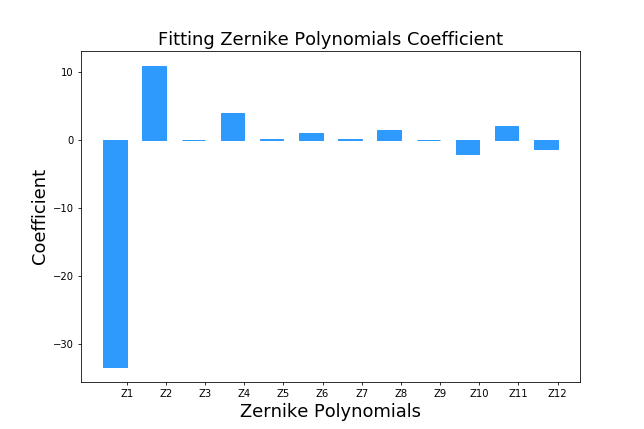

<IPython.core.display.Javascript object>


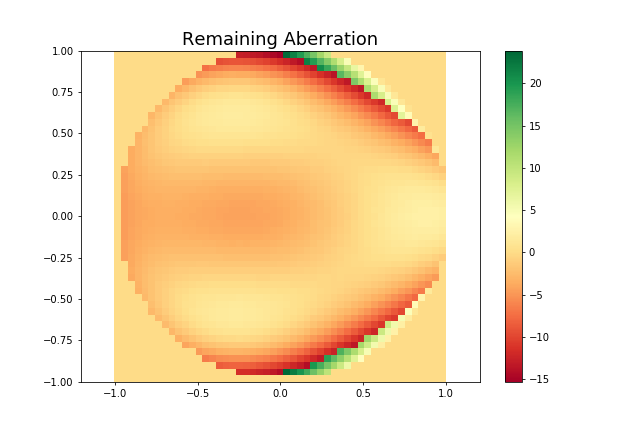

                            Zernike Polynomials List                              
----------------------------------------------------------------------------------
|   Z1  |   Z2  |   Z3  |   Z4  |   Z5  |   Z6  |   Z7  |   Z8  |   Z9  |  Z10  |
----------------------------------------------------------------------------------
| 0.000 |10.871 |-0.059 | 3.991 | 0.143 | 1.039 | 0.157 | 1.463 | 0.009 |-2.043 |
----------------------------------------------------------------------------------
|  Z11  |  Z12  |  Z13  |  Z14  |  Z15  |  Z16  |  Z17  |  Z18  |  Z19  |  Z20  |
----------------------------------------------------------------------------------
| 2.043 |-1.394 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 | 0.000 |
----------------------------------------------------------------------------------
|  Z21  |  Z22  |  Z23  |  Z24  |  Z25  |  Z26  |  Z27  |  Z28  |  Z29  |  Z30  |
----------------------------------------------------------------------------------
| 0.000 |

In [9]:
import opticspy
fitlist,C1 = opticspy.zernike.fitting(z,12,remain2D=1,barchart=1)

<IPython.core.display.Javascript object>


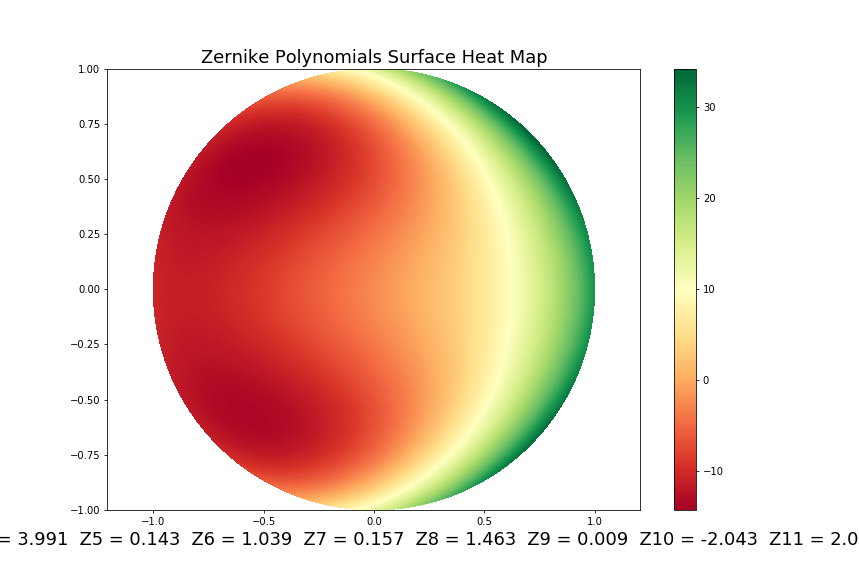

Z2 =  10.871 Z11 x Tilt
Z3 =  -0.059 Z11 y Tilt
Z4 =  3.991 Z20 Defocus
Z5 =  0.143 Z22 Primary Astigmatism at 45
Z6 =  1.039 Z22 Primary Astigmatism at 0
Z7 =  0.157 Z31 Primary y Coma
Z8 =  1.463 Z31 Primary x Coma
Z9 =  0.009 Z33 y Trefoil
Z10 =  -2.043 Z33 x Trefoil
Z11 =  2.043 Z40 Primary Spherical
Z12 =  -1.394 Z42 Secondary Astigmatism at 0


In [10]:
C1.zernikemap()

<IPython.core.display.Javascript object>


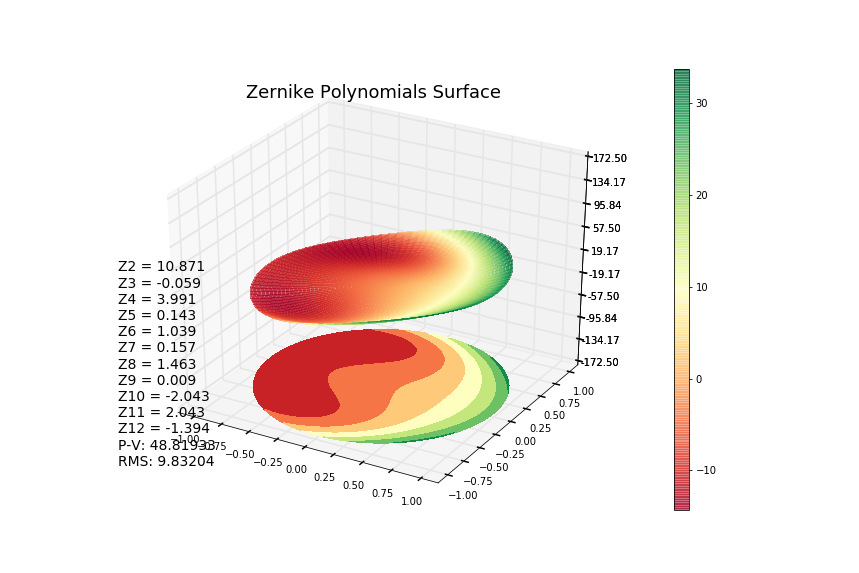

Z2 =  10.871 Z11 x Tilt
Z3 =  -0.059 Z11 y Tilt
Z4 =  3.991 Z20 Defocus
Z5 =  0.143 Z22 Primary Astigmatism at 45
Z6 =  1.039 Z22 Primary Astigmatism at 0
Z7 =  0.157 Z31 Primary y Coma
Z8 =  1.463 Z31 Primary x Coma
Z9 =  0.009 Z33 y Trefoil
Z10 =  -2.043 Z33 x Trefoil
Z11 =  2.043 Z40 Primary Spherical
Z12 =  -1.394 Z42 Secondary Astigmatism at 0


In [11]:
C1.zernikesurface()

### TBD: avoid the kluge of just interpolating the center 